# Classifying stars and galaxies using machine learning

Authored by Maksim Nikiforov

NCSU ST590, Project 3

Spring, 2022

In [69]:
# Import required libraries and set up Spark session

# import os
# import sys
# os.environ['PYSPARK_PYTHON'] = sys.executable
# os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import matplotlib.pyplot as plt
import pyspark.pandas as ps
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

## Introduction

Since 2000, the [Sloan Digital Sky Survey (SDSS)](https://www.sdss.org/) has cataloged hundreds of parameters for millions of celestial objects and has inspired nearly 11,000 peer-reviewed publications, making it "one of the most successful surveys in the history of astronomy"   <cite id="2qy3z"><a href="#zotero|6578788/Z75D4M6Y">(<i>Sloan Digital Sky Surveys | SDSS</i>, n.d.)</a></cite>. This notebook investigates a subset of the survey data. The intent of this exercise is to perform binary classification of photometric data using supervised learning, classifying observations from the Sloan Digital Sky Survey as either "stars" or "galaxies".   

The sections that follow introduce the Sloan Digital Sky Survey Data Release 7 and outline steps to retrieve its photometric data. [Section 2](#supervised_learning) provides a brief overview of supervised learning and its applicability in astronomy. This section also splits the photometric data into training and test sets in preparation for supervised model development. [Section 3](#eda) explores the training data in-depth. [Section 4](#modeling) introduces a variety of supervised learning algorithms and trains models using historic observations. These models are then applied to test data to evaluate how well they generalize with unseen objects. [Section 5](#conclusion) concludes the notebook with remarks about the findings of this exercise.         

## Data source and description

The data in this notebook is retrieved by querying the [CasJobs](https://skyserver.sdss.org/CasJobs/default.aspx) workbench for Data Release 7 (DR7), the seventh major data release from the Sloan Digital Sky Survey, with the SQL query below. Access to CasJobs is available to registered users of the [SciServer](https://www.sciserver.org/) online science platform. The query is credited to Vasconcellos et al., whose paper provides domain expertise for selecting features that "are known or expected to strongly correlate with the object classification" <cite id="41heo"><a href="#zotero|6578788/UXVJ3YSM">(Vasconcellos et al., 2011)</a></cite>.

```
 SELECT

    p.objID, p.ra, p.dec, s.specObjID,
    p.psfMag_r, p.modelMag_r, p.petroMag_r,
    p.fiberMag_r, p.petroRad_r, p.petroR50_r,
    p.petroR90_r, p.lnLStar_r,p.lnLExp_r,
    p.lnLDeV_r, p.mE1_r, p.mE2_r, p.mRrCc_r,
    p.type_r,p.type, s.specClass

 FROM PhotoObj AS p

    JOIN SpecObj AS s ON s.bestobjid = p.objid

 WHERE

    p.modelMag_r BETWEEN 14.0 AND 21.0

```

This SQL request retrieves 1,030,220 rows of observations with the following schema:

In [70]:
# Read CSV into a Spark DataFrame
sdss_data = spark.read.options(header="True", inferSchema="True", delimiter=",").csv(
    "sdss_dr7_observations.csv"
)

# View number of observations in the full CSV
print("Number of observations:", sdss_data.count())

Number of observations: 299629


In [71]:
# Print the columns and column types in the DataFrame
print("SDSS DR7 schema:")
sdss_data.printSchema()

SDSS DR7 schema:
root
 |-- objID: long (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- specObjID: long (nullable = true)
 |-- psfMag_r: double (nullable = true)
 |-- modelMag_r: double (nullable = true)
 |-- petroMag_r: double (nullable = true)
 |-- fiberMag_r: double (nullable = true)
 |-- petroRad_r: double (nullable = true)
 |-- petroR50_r: double (nullable = true)
 |-- petroR90_r: double (nullable = true)
 |-- lnLStar_r: double (nullable = true)
 |-- lnLExp_r: double (nullable = true)
 |-- lnLDeV_r: double (nullable = true)
 |-- mE1_r: double (nullable = true)
 |-- mE2_r: double (nullable = true)
 |-- mRrCc_r: double (nullable = true)
 |-- type_r: integer (nullable = true)
 |-- type: integer (nullable = true)
 |-- specClass: integer (nullable = true)



The table below describes these attributes.

<style type="text/css">
.tg  {border-collapse:collapse;border-color:#ccc;border-spacing:0;margin:0px auto;}
.tg td{background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;
  font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;
  font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-fymr{border-color:inherit;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-7btt{border-color:inherit;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-btxf{background-color:#f9f9f9;border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-abip{background-color:#f9f9f9;border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-dzk6{background-color:#f9f9f9;text-align:center;vertical-align:top}
@media screen and (max-width: 767px) {.tg {width: auto !important;}.tg col {width: auto !important;}.tg-wrap {overflow-x: auto;-webkit-overflow-scrolling: touch;margin: auto 0px;}}</style>
<div class="tg-wrap"><table class="tg">
<thead>
  <tr>
    <th class="tg-fymr">Feature</th>
    <th class="tg-7btt">CAS Variable</th>
    <th class="tg-7btt">Description<br></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-btxf">PSF magnitude</td>
    <td class="tg-abip">  psfMag</td>
    <td class="tg-btxf">For isolated stars, which are well-described by the point spread function (PSF), the optimal measure of the total flux is determined by fitting a PSF model to the object.</td>
  </tr>
  <tr>
    <td class="tg-0pky">Fiber magnitude</td>
    <td class="tg-c3ow">  fiberMag</td>
    <td class="tg-0pky">The flux contained within the aperture of a spectroscopic fiber</td>
  </tr>
  <tr>
    <td class="tg-btxf">Petrosian magnitude</td>
    <td class="tg-abip">  petroMag</td>
    <td class="tg-btxf">A measure of galaxy flux within a circular aperture whose radius is defined by the shape of the azimuthally averaged light profile</td>
  </tr>
  <tr>
    <td class="tg-0pky">Model magnitude</td>
    <td class="tg-c3ow">  modelMag</td>
    <td class="tg-0pky">Magnitudes that result from fitting a deVaucouleurs profile or an exponential profile to the two-dimensional image of each object in each band</td>
  </tr>
  <tr>
    <td class="tg-btxf">Petrosian radius</td>
    <td class="tg-abip">  petroRad</td>
    <td class="tg-btxf">The radius at which the Petrosian ratio equals 0.2. </td>
  </tr>
  <tr>
    <td class="tg-0pky">Radius carrying 50% of Petrosian flux</td>
    <td class="tg-c3ow">  petroR50</td>
    <td class="tg-0pky">The radii containing 50% of the Petrosian flux for each band</td>
  </tr>
  <tr>
    <td class="tg-btxf">Radius carrying 90% of Petrosian flux</td>
    <td class="tg-abip">  petroR90</td>
    <td class="tg-btxf">The radii containing 90% of the Petrosian flux for each band</td>
  </tr>
  <tr>
    <td class="tg-0pky">Likelihood PSF</td>
    <td class="tg-c3ow">  lnLStar</td>
    <td class="tg-0pky">The probabilities of achieving the measured chi-squared for the PSF fits</td>
  </tr>
  <tr>
    <td class="tg-btxf">Likelihood exponential</td>
    <td class="tg-abip">  lnLExp</td>
    <td class="tg-btxf">the probabilities of achieving the measured chi-squared for the exponential fits</td>
  </tr>
  <tr>
    <td class="tg-0pky">Likelihood deVaucouleurs</td>
    <td class="tg-c3ow">  lnLDeV</td>
    <td class="tg-0pky">The probabilities of achieving the measured chi-squared for the deVaucouleurs fits</td>
  </tr>
  <tr>
    <td class="tg-btxf">Adaptive moments</td>
    <td class="tg-abip">  mRrCc, mE1, mE2</td>
    <td class="tg-btxf">A method of measuring object shapes. These moments are close to optimal for measuring the shapes of faint galaxies, and have been used for weak lensing studies.</td>
  </tr>
  <tr>
    <td class="tg-0pky">Spectroscopic classification</td>
    <td class="tg-c3ow">  specClass</td>
    <td class="tg-0pky">Indicates the best-matching spectroscopic template. SpecClass = 1 is associated some kind of star, SpecClass = 2 means galaxy, and SpecClass = 3 or 4 means quasar.</td>
  </tr>
  <tr>
    <td class="tg-dzk6" colspan="3"><span style="font-weight:bold">Table 1</span>:  Attributes from the Sloan Digital Sky Survey Data Release 7 that have been deemed useful in classifying objects as stars or galaxies. </td>
  </tr>
</tbody>
</table></div>

A [schema browser](http://cas.sdss.org/dr7/en/help/browser/browser.asp) as well as a [Glossary of SDSS Terminology](http://classic.sdss.org/dr7/glossary/index.html) provide supplementary explanations for the remaining column in the data. These references show that, in the data sample below, rows in the integer-based `type` column equate to $3$ for "galaxies" and $6$ for "stars". The `SpecClass` column further subdivides observations into quasi-stellar objects (`specClass` = 3), blank-sky spectrums (`specClass` = 5), high-redshift quasars (`specClass` = 4), and unclassifiable spectrums (`specClass` = 0). These make up only a small number of observations, and the sections that follow will filter data to include only stars (`specClass` = 1) and galaxies (`specClass` = 2).   

In [5]:
# Temporarily convert to pandas-on-spark DataFrame for
# better appearance and print a sample of rows
sdss_data.to_pandas_on_spark().sample(frac=0.00002, random_state=375)

,objID,ra,dec,specObjID,psfMag_r,modelMag_r,petroMag_r,fiberMag_r,petroRad_r,petroR50_r,petroR90_r,lnLStar_r,lnLExp_r,lnLDeV_r,mE1_r,mE2_r,mRrCc_r,type_r,type,specClass
47967,587737809564008590,111.840404,38.935551,488023971736846336,17.72737,17.70484,17.75885,18.05289,1.142078,0.588535,1.350012,-1.499092,-0.403603,-0.407868,0.001695,-0.047742,2.520975,6,6,3
73869,587722983357415495,195.400539,0.032763,82695481016188928,17.60798,17.60427,17.65812,17.94762,1.206996,0.615739,1.368821,-0.083936,-0.120774,-0.120695,-0.059635,0.001535,2.816326,6,6,3
95055,587727226765312242,3.397407,-9.640221,183745617489559552,19.94043,18.76039,18.71560,19.87487,4.819426,1.937682,6.295853,-329.264700,-45.277520,-0.358122,0.038327,-0.061077,7.518435,3,3,2
107804,587727178448175257,357.022896,-10.711600,182621524333690880,19.51554,17.84025,17.85469,19.48932,6.483387,2.973348,7.683743,-2643.199000,-23.321170,-154.238800,0.162918,0.882215,97.278930,3,3,2
141360,587742903400267794,189.977076,17.805380,732067913300705280,18.86029,18.77594,18.79062,19.09767,1.081241,0.538625,1.330721,-33.510780,-11.106710,-9.696114,-0.055893,-0.017244,1.951671,6,6,3


<a id="supervised_learning"></a>
# Supervised learning

## Overview

When SDSS Data Release 7 became publicly available in 2008, it consisted of 15.7 TB of FITS image data, 18 TB of catalogs, and 26.8 TB of "other" data products <cite id="fb21r"><a href="#zotero|6578788/WRVILYFW">(<i>SDSS Data Release 7</i>, 2013)</a></cite>. Subsequent releases - DR8 through DR16 - swelled to 407 TB in volume, and the newest DR17 alone contains 245 TB of data <cite id="drr5l"><a href="#zotero|6578788/M4AXTGNR">(<i>Data Volume | SDSS</i>, 2021)</a></cite>. These size pale in comparison to the planned productivity of the Vera C. Rubin Observatory, which is expected to produce upwards of 500 petabytes of images and other data products <cite id="b20i6"><a href="#zotero|6578788/3B8U6ZL5">(<i>About Rubin Observatory | Rubin Observatory</i>, 2022)</a></cite>. Such vast pools of information are expected to require unsupervised and supervised learning to help automatically "locate, classify, and characterize objects" and to discover "new fundamental relationships between derived properties" <cite id="3wnhz"><a href="#zotero|6578788/LXV9B3I3">(Fluke &#38; Jacobs, 2020)</a></cite>.      

Supervised learning is the technique of using regression or classification algorithms and known variables ("predictors" or "features") to train models that predict numeric outputs or categorize observations based on probability. The act of "training" models involves using historical data, such as the SDSS DR7, to "find the relationship that has the best predictive power" for new observations <cite id="bkbzf"><a href="#zotero|6578788/ELIRRS3L">(Tatsat et al., 2020)</a></cite>. To avoid overfitting a model to training data, it is common practice to split historical data into "training" and "test" sets during model development. The training data is used to teach a model how to predict or classify an observation, while test data helps practitioners quantify model performance with unseen observations.  

## Data clean-up

Before splitting the sample DR7 data into train and test sets, it is prudent to investigate and resolve any missing values. Column- and subsequently row-wise summation indicates that there are a little over 7,000 missing values in the data.  

In [6]:
# Count total number of missing values.
# "Missing" values include 0, -9999, NaN, and Null

# Solution is based on examples from
# https://sparkbyexamples.com/pyspark/pyspark-find-count-of-null-none-nan-values/
# and
# https://stackoverflow.com/questions/53297872/how-can-i-sum-multiple-columns-in-a-spark-dataframe-in-pyspark

import pyspark.sql.functions as F

# Create a DataFrame with one row in which each column
# includes count of total missing values in that column
df_zero = sdss_data.select(
    [
        F.count(
            F.when(
                (sdss_data[c] == 0)
                | (sdss_data[c] == -9999)
                | (F.isnan(sdss_data[c]))
                | (sdss_data[c].isNull()),
                c,
            )
        ).alias(c)
        for c in sdss_data.columns
    ]
)

# Retrieve names of all columns
cols_list = df_zero.columns

# Parse an expression to sum the number of
# missing values across all rows
expression = "+".join(cols_list)

# Create a new column with the sum of missing values
# across all rows
df_sum = df_zero.withColumn("sum_missing", F.expr(expression))

# Display total number of missing values
df_sum.select("sum_missing").show()

+-----------+
|sum_missing|
+-----------+
|       7154|
+-----------+



Rows with missing data may be deleted entirely. However, to avoid losing information (and to gain additional practice), we can use Spark's [`Imputer`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Imputer.html) to fill in missing values with the mean or the median of their associated columns. 

In [7]:
# Replace -9999 and 0 with "None"
# sdss_data = sdss_data.replace(-9999, None)
# sdss_data = sdss_data.replace(0, None)

In [8]:
# Remove rows with missing values and calculate new row count
# sdss_data = sdss_data.dropna()
# print("New row count, no missing values:\n", sdss_data.count())

The data also includes objects for which the spectrum is not classifiable (`specClass` = 0) or where the spectrum is that of a quasi-stellar object (`specClass` = 3), a high-redshift quasar (`specClass` = 4), a blank sky (`specClass` = 5), or of another class of object. Since the goal of this activity is binary classification, the data should be filtered to include only stars (`specClass` = 1) and galaxies (`specClass` = 2).

In [9]:
# Filter DataFrame to include only the objects which are
# classified as either a "star" or a "galaxy".
# Print the new observation count.
sdss_data = sdss_data.filter((sdss_data.specClass == 1) | (sdss_data.specClass == 2))
print("Count of stars and galaxies only:\n", sdss_data.count())

Count of stars and galaxies only:
 169608


Lastly, a new column called `obj_category` can be created to translate the integer-based `type` column to a human-readable classification. This column will be useful for constructing plots, but it will not be a feature for supervised learning models.

In [10]:
from pyspark.sql.functions import col, when

# Create a rule to equate type=3 with "galaxy" and type=6 with "star"
conditions = when(col("type") == "6", "Star").when(col("type") == "3", "Galaxy")

# Apply the new rule to create a new column with
# human-readable classification labels
sdss_data = sdss_data.withColumn("obj_category", conditions)

# Retrieve a data subset with new column
sdss_data[["objID", "type", "obj_category"]].sample(fraction=0.00003, seed=1).show()

+------------------+----+------------+
|             objID|type|obj_category|
+------------------+----+------------+
|587724233174745260|   3|      Galaxy|
|587725551205613742|   3|      Galaxy|
|587725469590225198|   3|      Galaxy|
|587736585515565247|   6|        Star|
|587729387149787196|   6|        Star|
+------------------+----+------------+



## Data split - training and test sets

After filtering observations to only include stars and galaxies, 70% of the data may be set aside for training supervised models and 30% may be reserved for evaluating model performance. 

In [11]:
# 70/30 dataset split
train, test = sdss_data.randomSplit([0.7, 0.3])

<a id="eda"></a>
# Exploratory data analysis

After a 70/30 split, the training data contains a little less than 120,000 observations. 

In [12]:
# Row count in training data
print("Training data row count:", train.count())

Training data row count: 118817


Approximately half are classified as galaxies and half are classified as stars. This nearly-even split is indicative of a well-balanced training set. 

(array([0, 1]), [Text(0, 0, 'Galaxy'), Text(1, 0, 'Star')])

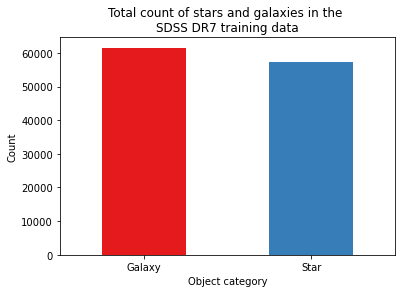

In [13]:
# Use matplotlib in lieu of plotly
ps.options.plotting.backend = 'matplotlib'

# Categorize objects in the training data by their classification
# and obtain counts. Convert result to a pandas-on-spark DataFrame
object_count = train.groupBy("obj_category").count().to_pandas_on_spark()

# Color palette from
# https://predictablynoisy.com/matplotlib/gallery/color/colormap_reference.html#sphx-glr-gallery-color-colormap-reference-py
col_map = plt.get_cmap('Set1')

# Create a bar graph of total object counts in the
# training data
object_count.plot.bar(x="obj_category", 
                      y="count", 
                      figsize =(6, 4),
                      color=col_map.colors,
                      legend=None
                     )
plt.title("Total count of stars and galaxies in the \nSDSS DR7 training data")
plt.xlabel("Object category")
plt.ylabel("Count")
plt.xticks(rotation=0)

The Aitoff projection below shows the distribution of the galaxies and stars captured by Data Release 7. Most of the observations reside in the North Galactic Cap, although the three stripes extend as far as the South Galactic Cap at a declination of nearly $-15^{\circ}$

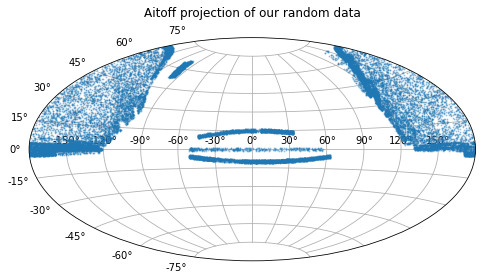

In [14]:
import ligo.skymap.plot
from astropy import units as u
from astropy.coordinates import SkyCoord

# Astropy has not been modified to work with PySpark DataFrames.
# Therefore, convert "ra" and "dec" to a pandas DataFrame.
equatorial_coord = (
    train[["ra", "dec"]].sample(fraction=0.2).to_pandas_on_spark().to_pandas()
)

# Assign "degree" units to "ra" and "dec" column
c = SkyCoord(
    ra=equatorial_coord["ra"] * u.degree,
    dec=equatorial_coord["dec"] * u.degree,
    frame="icrs",
)

# The azimuthal angle is expected to be between (-180º,180º),
# so wrap "ra" to to the interval this interval
ra_angle = c.ra.wrap_at(180 * u.degree)

# Plot the projection using matplotlib
plt.figure(figsize=(8, 4.2))
plt.subplot(111, projection="aitoff")
plt.title("Aitoff projection of our random data\n")
plt.grid(True)
plt.plot(ra_angle.radian, c.dec.radian, "o", markersize=1, alpha=0.3)

Photometry pipelines are in place to help classify the 1.5 million objects in the SDSS Data Release 7 set. These pipelines monitor the difference between the PSF magnitude (`psfMag`) and the model magnitude (`cmodel`) for observed objects and use $0.145$ as the threshold for classification; objects which exceed this difference in value are branded as "galaxies", and all others are set to "stars". This separation is clear in the scatter plot below, with all but a few stars residing beneath the $0.145$ threshold. 

In [15]:
# Calculate difference between psfMag and modelMag and create new column with results
train = train.withColumn("psfModelDiff", train.psfMag_r - train.modelMag_r)

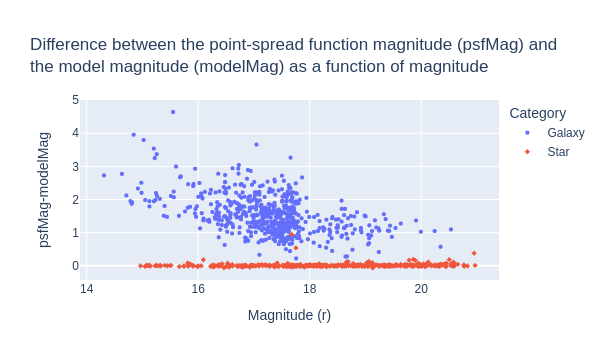

In [19]:
ps.options.plotting.backend = "plotly"

import plotly.graph_objects as go

fig = train.sample(fraction=0.1, seed=5).to_pandas_on_spark().plot.scatter(
    x="modelMag_r",
    y="psfModelDiff",
    color="obj_category",
    symbol="obj_category",
    title="Difference between the point-spread function magnitude (psfMag) and <br>the model magnitude (modelMag) as a function of magnitude",
    labels=dict(
        modelMag_r="Magnitude (r)",
        psfModelDiff="psfMag-modelMag",
        obj_category="Category",
    ),
)

fig.update_traces(marker_size=4)

The magnitudes of stars that are closely accompanied by galaxies may be incorrect, and the use of supervised learning can help decrease the rate of misclassification. The distribution of object magnitudes, `modelMag_r`, in the training data is unimodal and skewed left, peaking in the range between $17.5-18$. 

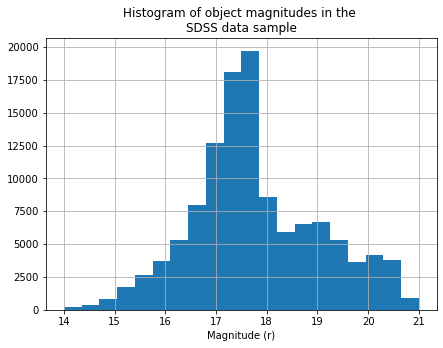

In [17]:
# Magnitude distribution
# Using matplotlib because of a known bug in which plotly
# does not display title, https://issues.apache.org/jira/browse/SPARK-37188
plt.figure(figsize=(7, 5))
plt.hist(train.to_pandas_on_spark().modelMag_r, bins=20)
plt.xlabel("Magnitude (r)")
plt.title("Histogram of object magnitudes in the \nSDSS data sample")
plt.grid(True)

Galaxies and stars have an average magnitude of 17.27 and 18.31, respectively. Since the magnitude scale is logarithmic, galaxies are approximately 2.6 times brighter than stars.

In [97]:
from pyspark.sql.functions import max, mean, min, stddev

# Group objects by category, and then
# obtain basic statistical summaries for object magnitudes.
# Convert to pandas-on-spark DataFrame for presentability
train.groupby("obj_category").agg(
    mean("modelMag_r"), min("modelMag_r"), max("modelMag_r"), stddev("modelMag_r")
).to_pandas_on_spark()

,obj_category,avg(modelMag_r),min(modelMag_r),max(modelMag_r),stddev_samp(modelMag_r)
0,Galaxy,17.290822,14.00007,20.99957,0.916101
1,Star,18.310017,14.16695,20.99920,1.384029


<a id="modeling"></a>
# Modeling

In [48]:
# Create our list of features

col_list = train.select(
    [
        "psfMag_r",
        "modelMag_r",
        "petroMag_r",
        "fiberMag_r",
        "petroRad_r",
        "petroR50_r",
        "petroR90_r", 
        "lnLStar_r",
        "lnLExp_r",
        "lnLDeV_r",
        "mE1_r",
        "mE2_r",
        "mRrCc_r",
    ]
).columns

## Set up transformations

In [49]:
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=col_list,
                      outputCols=    [
        "psfMag_r_imp",
        "modelMag_r_imp",
        "petroMag_r_imp",
        "fiberMag_r_imp",
        "petroRad_r_imp",
        "petroR50_r_imp",
        "petroR90_r_imp",
        "lnLStar_r_imp",
        "lnLExp_r_imp",
        "lnLDeV_r_imp",
        "mE1_r_imp",
        "mE2_r_imp",
        "mRrCc_r_imp",
    ])

In [50]:
features_list = [
        "psfMag_r_imp",
        "modelMag_r_imp",
        "petroMag_r_imp",
        "fiberMag_r_imp",
        "petroRad_r_imp",
        "petroR50_r_imp",
        "petroR90_r_imp",
        "lnLStar_r_imp",
        "lnLExp_r_imp",
        "lnLDeV_r_imp",
        "mE1_r_imp",
        "mE2_r_imp",
        "mRrCc_r_imp",
    ]

In [22]:
#from pyspark.ml.feature import SQLTransformer

#sqlTrans = SQLTransformer(
#    statement="SELECT psfMag_r, modelMag_r, petroMag_r, fiberMag_r, \
#                        petroRad_r, petroR50_r, petroR90_r, lnLStar_r, \
#                        lnLExp_r, lnLDeV_r, mE1_r, mE2_r, mRrCc_r, \
#                        type FROM __THIS__"
#)

In [51]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler

assembler = VectorAssembler(inputCols=features_list, outputCol="features")

# scaler = StandardScaler(inputCol="unscaledFeatures", outputCol="features")

## Logistic regression

In [52]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol="obj_category", outputCol="label", handleInvalid="skip")

In [53]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()

The list of available logistic regression attributes in PySpark is available [here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html#pyspark.ml.classification.LogisticRegression.aggregationDepth).

In [56]:
lr_pipeline = Pipeline(stages=[imputer, stringIndexer, assembler, lr])

In [57]:
import numpy as np
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator,
)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

lr_ParamGrid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, np.arange(0, 0.1, 0.01))
    .addGrid(lr.elasticNetParam, [0, 1])
    .build()
)

lr_evaluator = BinaryClassificationEvaluator(
    labelCol="label",                    
    rawPredictionCol="rawPrediction",      
    metricName="areaUnderROC",
)

lr_CrossVal = CrossValidator(
    estimator=lr_pipeline,
    estimatorParamMaps=lr_ParamGrid,
    evaluator=lr_evaluator,
    numFolds=3,
)

In [58]:
lr_CVModel = lr_CrossVal.fit(train)

In [59]:
lr_Predictions = lr_CVModel.transform(test)

In [60]:
lr_Predictions.select("prediction", "rawPrediction", "probability").show(3, True)

+----------+--------------------+--------------------+
|prediction|       rawPrediction|         probability|
+----------+--------------------+--------------------+
|       0.0|[10.6977497079190...|[0.99997740478282...|
|       0.0|[9.11171732144737...|[0.99988964715901...|
|       0.0|[21.8943775091305...|[0.99999999968997...|
+----------+--------------------+--------------------+
only showing top 3 rows



### Evaluating the logistic regression model

A confusion matrix can contrast the results of the supervised training model against the true classifications of thr stellar objects. 

<div class="tg-wrap"><table>
<thead>
  <tr>
    <th rowspan="4"><br><br><br><br>Label</th>
    <th colspan="3">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Prediction</th>
  </tr>
  <tr>
    <th></th>
    <th>0</th>
    <th>1</th>
  </tr>
  <tr>
    <th>0</th>
    <th>True negative</th>
    <th>False positive</th>
  </tr>
  <tr>
    <th>1</th>
    <th>False negative</th>
    <th>True positive</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td colspan="4">Figure 1: The anatomy of a confusion matrix. </td>
  </tr>
</tbody>
</table></div>

In [63]:
# Create a confusion matrix for the logistic regression model
print("Logistic regression \nconfusion matrix:")
lr_Predictions.groupby("obj_category").pivot("prediction").count().show()

Logistic regression 
confusion matrix:
+------------+-----+-----+
|obj_category|  0.0|  1.0|
+------------+-----+-----+
|      Galaxy|26087|  286|
|        Star|  123|24295|
+------------+-----+-----+



In [64]:
lr_evaluator.evaluate(lr_Predictions)

0.9994149424041973

In [65]:
lr_Predictions.filter(lrPredictions.modelMag_r >= 20.5).count()

910

In [66]:
print(
    "Accuracy:",
    lr_evaluator.evaluate(
        lr_Predictions.filter(lrPredictions.modelMag_r >= 20.5)
    ),
)

Accuracy: 0.9456341744084873


In [67]:
lr_Predictions.filter(
    (lr_Predictions.modelMag_r >= 20.5)
    & (lr_Predictions.label != lr_Predictions.prediction)
).select(["objID", "label", "prediction"]).show(5)

+------------------+-----+----------+
|             objID|label|prediction|
+------------------+-----+----------+
|587726879410422590|  1.0|       0.0|
|587724198279971122|  0.0|       1.0|
|587727264349619714|  0.0|       1.0|
|587724231569440810|  0.0|       1.0|
|587726031179088000|  1.0|       0.0|
+------------------+-----+----------+
only showing top 5 rows



In [58]:
from IPython.core.display import HTML
from IPython.display import Image

Image(
    url="http://skyservice.pha.jhu.edu/DR7/ImgCutout/getjpeg.aspx?ra=197.99224324&dec=-1.17760226&scale=0.2&width=200&height=200&opt=G"
)

## Random forest classifier

In [37]:
from pyspark.ml.classification import RandomForestClassifier

rfc = RandomForestClassifier(labelCol="label", featuresCol="features")

Finally, we can set up a pipeline.

In [38]:
rfc_pipeline = Pipeline(stages=[stringIndexer, assembler, rfc])

We can then set up cross-validation.

In [39]:
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator,
)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

rfcParamGrid = (
    ParamGridBuilder()
    .addGrid(rfc.maxDepth, [0, 10, 20, 30])
    .addGrid(rfc.numTrees, [5, 10, 20, 30, 40])
    .build()
)

evaluator = BinaryClassificationEvaluator(
    labelCol="label",                    
    rawPredictionCol="rawPrediction",      
    metricName="areaUnderROC",
)

rfcCrossVal = CrossValidator(
    estimator=rfc_pipeline,
    estimatorParamMaps=rfcParamGrid,
    evaluator=evaluator,
    numFolds=3,
)

In [40]:
# Run cross-validation and choose the best set of parameters

rfc_cv_model = rfcCrossVal.fit(train)

In [41]:
rfcPredictions = rfc_cv_model.transform(test)

In [42]:
print("Accuracy:", evaluator.evaluate(rfcPredictions))

Accuracy: 0.999787401540977


In [43]:
# Create a confusion matrix for the random forest model
print("Logistic regression \nconfusion matrix:")
rfcPredictions.groupby("obj_category").pivot("prediction").count().show()

Logistic regression 
confusion matrix:


+------------+-----+-----+
|obj_category|  0.0|  1.0|
+------------+-----+-----+
|      Galaxy|26200|  167|
|        Star|  146|24247|
+------------+-----+-----+



In [46]:
rfcPredictions.select("features", "obj_category", "prediction").show(5)

+--------------------+------------+----------+
|            features|obj_category|prediction|
+--------------------+------------+----------+
|[19.50751,17.1084...|      Galaxy|       0.0|
|[18.76937,18.1794...|      Galaxy|       0.0|
|[19.3819,17.46996...|      Galaxy|       0.0|
|[17.01301,14.8232...|      Galaxy|       0.0|
|[20.43995,19.4842...|      Galaxy|       0.0|
+--------------------+------------+----------+
only showing top 5 rows



In [44]:
print(
    "Accuracy:",
    evaluator.evaluate(
        rfcPredictions.filter(rfcPredictions.modelMag_r >= 20.5)
    ),
)

Accuracy: 0.9717147110569766


In [45]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="prediction",
    metricName="areaUnderROC",
)

accuracy = evaluator.evaluate(rfcPredictions)
print(f"Area under ROC = {accuracy} ")

Area under ROC = 0.9938405008362398 


## Decision tree

In [61]:
from pyspark.ml.classification import DecisionTreeClassifier

dtClassifier = DecisionTreeClassifier()

dtPipeline = Pipeline().setStages([sqlTrans, assembler, dtClassifier])

In [62]:
dtParamGrid = ParamGridBuilder().addGrid(dtClassifier.maxDepth, [0, 5, 10, 20]).build()

dtCrossVal = CrossValidator(
    estimator=dtPipeline,
    estimatorParamMaps=dtParamGrid,
    evaluator=MulticlassClassificationEvaluator(),
    numFolds=3,
)

In [63]:
# Run cross-validation, and choose the best set of parameters

dtCVModel = dtCrossVal.fit(train)

In [64]:
dtPredictions = dtCVModel.transform(test)

In [65]:
print("Accuracy:", MulticlassClassificationEvaluator().evaluate(dtPredictions))

Accuracy: 0.9937226278921604


## Gradient-boosted trees

In [87]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol="type", outputCol="label", handleInvalid="skip")

gbtSQLTrans = SQLTransformer(
    statement="SELECT psfMag_r, modelMag_r, petroMag_r, fiberMag_r, \
                        petroRad_r, petroR50_r, petroR90_r, lnLStar_r, \
                        lnLExp_r, lnLDeV_r, mE1_r, mE2_r, mRrCc_r, \
                        label FROM __THIS__"
)

gbtClassifier = GBTClassifier()

gbtPipeline = Pipeline().setStages([stringIndexer, gbtSQLTrans, assembler, gbtClassifier])

In [88]:
gbtParamGrid = (
    ParamGridBuilder().addGrid(gbtClassifier.maxDepth, [0, 5, 10, 20]).build()
)

gbtCrossVal = CrossValidator(
    estimator=gbtPipeline,
    estimatorParamMaps=gbtParamGrid,
    evaluator=MulticlassClassificationEvaluator(),
    numFolds=3,
)

In [89]:
gbtCVModel = gbtCrossVal.fit(train)

In [90]:
gbtPredictions = gbtCVModel.transform(test)

In [91]:
print(
    "Accuracy:",
    MulticlassClassificationEvaluator().evaluate(
        gbtPredictions.filter(gbtPredictions.modelMag_r >= 20.5)
    ),
)

Accuracy: 0.9443559120437752


<a id="conclusion"></a>
# Conclusion

# References

<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry"><i id="zotero|6578788/3B8U6ZL5"></i><i>About Rubin Observatory | Rubin Observatory</i>. (2022). Vera C. Rubin Observatory. <a href="https://www.lsst.org/about">https://www.lsst.org/about</a></div>
  <div class="csl-entry"><i id="zotero|6578788/M4AXTGNR"></i><i>Data Volume | SDSS</i>. (2021). Sloan Digital Sky Survey. <a href="https://www.sdss.org/dr17/data_access/volume">https://www.sdss.org/dr17/data_access/volume</a></div>
  <div class="csl-entry"><i id="zotero|6578788/LXV9B3I3"></i>Fluke, C. J., &#38; Jacobs, C. (2020). Surveying the reach and maturity of machine learning and artificial intelligence in astronomy. <i>WIREs Data Mining and Knowledge Discovery</i>, <i>10</i>(2), e1349. <a href="https://doi.org/10.1002/widm.1349">https://doi.org/10.1002/widm.1349</a></div>
  <div class="csl-entry"><i id="zotero|6578788/WRVILYFW"></i><i>SDSS Data Release 7</i>. (2013). Sloan Digital Sky Survey. <a href="http://classic.sdss.org/dr7/">http://classic.sdss.org/dr7/</a></div>
  <div class="csl-entry"><i id="zotero|6578788/Z75D4M6Y"></i><i>Sloan Digital Sky Surveys | SDSS</i>. (n.d.). Retrieved April 28, 2022, from <a href="https://www.sdss.org/surveys/">https://www.sdss.org/surveys/</a></div>
  <div class="csl-entry"><i id="zotero|6578788/ELIRRS3L"></i>Tatsat, H., Puri, S., &#38; Lookabaugh, B. (2020). Machine Learning and Data Science Blueprints for Finance. In <i>Machine Learning and Data Science Blueprints for Finance</i>. O’Reilly Media. <a href="https://learning.oreilly.com/library/view/machine-learning-and/9781492073048/">https://learning.oreilly.com/library/view/machine-learning-and/9781492073048/</a></div>
  <div class="csl-entry"><i id="zotero|6578788/UXVJ3YSM"></i>Vasconcellos, E. C., Carvalho, R. R. de, Gal, R. R., LaBarbera, F. L., Capelato, H. V., Velho, H. F. C., Trevisan, M., &#38; Ruiz, R. S. R. (2011). DECISION TREE CLASSIFIERS FOR STAR/GALAXY SEPARATION. <i>The Astronomical Journal</i>, <i>141</i>(6), 189. <a href="https://doi.org/10.1088/0004-6256/141/6/189">https://doi.org/10.1088/0004-6256/141/6/189</a></div>
</div>
<!-- BIBLIOGRAPHY END -->